<a href="https://colab.research.google.com/github/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/blob/main/semestre2025-2/Sesiones/Sesion_01c_PruebasH_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from libs.linear_reg import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plots.style.use('fivethirtyeight')
%matplotlib inline

# Pruebas de hipotesis 1

In [2]:

# Leer los datos
births = pd.read_csv("DataSet/baby.csv")

# Hacer una copia
births = births.copy()

# Convertir unidades
births["Birth Weight"] = births["Birth Weight"] * 0.0283495
births["Maternal Height"] = births["Maternal Height"] * 0.0254
births["Maternal Pregnancy Weight"] = births["Maternal Pregnancy Weight"] * 0.453592


Maternal Smoker
False    715
True     459
dtype: int64


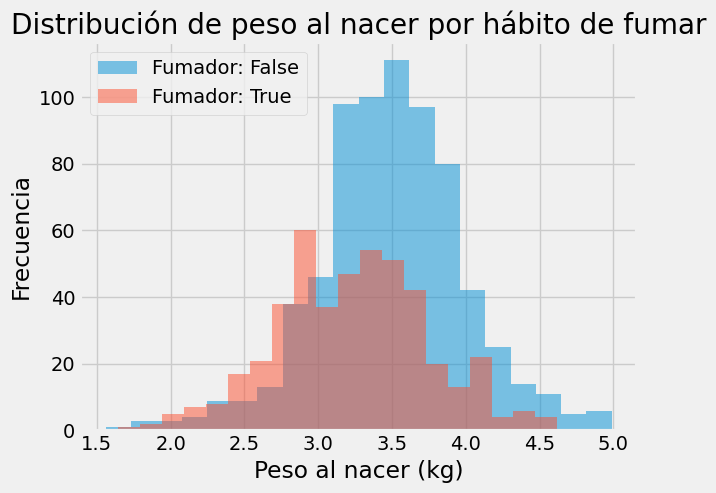

Maternal Smoker
False    3.489407
True     3.226717
Name: Birth Weight, dtype: float64


In [3]:
# Seleccionar columnas relevantes
fumador_peso_nacido = births[["Maternal Smoker", "Birth Weight"]]

# Agrupar por si la madre fumaba o no, contando registros
grupo = fumador_peso_nacido.groupby("Maternal Smoker").size()
print(grupo)

# Graficar histogramas separados por categoría de fumador
for categoria, grupo in fumador_peso_nacido.groupby("Maternal Smoker"):
    plt.hist(grupo["Birth Weight"], bins=20, alpha=0.5, label=f"Fumador: {categoria}")

plt.xlabel("Peso al nacer (kg)")
plt.ylabel("Frecuencia")
plt.title("Distribución de peso al nacer por hábito de fumar")
plt.legend()
plt.show()

# Calcular promedio de peso al nacer por hábito de fumar
peso_promedio = fumador_peso_nacido.groupby("Maternal Smoker")["Birth Weight"].mean()
print(peso_promedio)


**Hipotesis nula**: En la población, la distribución de los pesos natales de los bebés es la misma para las madres que no fuman que para las madres que lo hacen. La diferencia en la muestra se debe al azar.

**Hipotesis alternativa**: En la población, los bebés de las madres que fuman tienen un peso al nacer más bajo, en promedio, que los bebés de los no fumadores.

In [9]:
promedios = peso_promedio.values  
diferencia_observada = promedios[1] - promedios[0]
print("Diferencia Observada:", diferencia_observada)

Diferencia Observada: -0.2626905088456204


In [11]:
#Construyamos una funcion 
def diferencia_medias(df, group_label):
    means = df.groupby(group_label)["Birth Weight"].mean().values
    return means[1] - means[0]

In [12]:
print("Diferencia de medias real:", diferencia_medias(fumador_peso_nacido, 'Maternal Smoker'))

Diferencia de medias real: -0.2626905088456204


In [14]:
fumador_peso_nacido

,Maternal Smoker,Birth Weight
0,False,3.401940
1,False,3.203493
2,True,3.628736
3,True,3.061746
4,False,3.855532
...,...,...
1169,False,3.203493
1170,False,3.628736
1171,True,3.685435
1172,False,3.543687


In [7]:
#Bootstrap
shuffled_labels = fumador_peso_nacido["Maternal Smoker"].sample(frac=1, replace=False).reset_index(drop=True)
original_and_shuffled = fumador_peso_nacido.copy()
original_and_shuffled["Shuffled Label"] = shuffled_labels
original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Label
0,False,3.401940,False
1,False,3.203493,False
2,True,3.628736,False
3,True,3.061746,True
4,False,3.855532,False
...,...,...,...
1169,False,3.203493,False
1170,False,3.628736,True
1171,True,3.685435,False
1172,False,3.543687,False


In [8]:
shuffled_only = original_and_shuffled[["Birth Weight", "Shuffled Label"]]
# Diferencia de medias con etiquetas barajadas
print("Diferencia de medias barajada:", diferencia_medias(shuffled_only, "Shuffled Label"))

Diferencia de medias barajada: -0.010982780381492585


In [9]:
def diferentes_muestras():
    shuffled_labels = fumador_peso_nacido["Maternal Smoker"].sample(frac=1, replace=False).reset_index(drop=True)
    shuffled_only = fumador_peso_nacido.copy()
    shuffled_only["Shuffled Label"] = shuffled_labels
    shuffled_only = shuffled_only[["Birth Weight", "Shuffled Label"]]
    return diferencia_medias(shuffled_only, "Shuffled Label")

In [10]:
diferencias = []

repetitions = 1000
for _ in range(repetitions):
    diferencias.append(diferentes_muestras())


diferencias_df = pd.DataFrame({"Diferencia": diferencias})


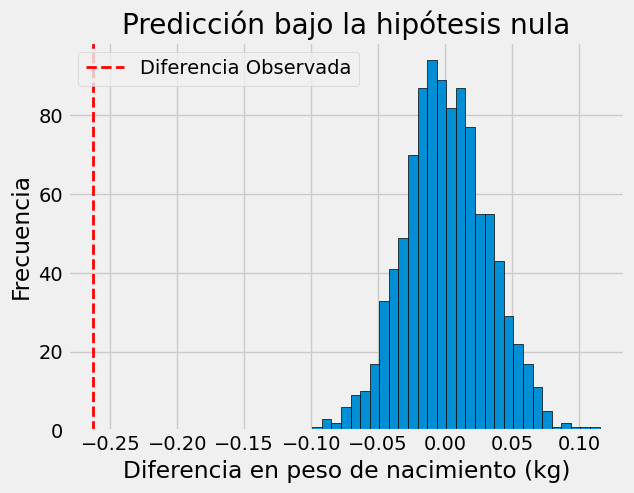

Diferencia Observada: -0.2626905088456204


In [11]:
# --- Graficar histograma ---
plt.hist(diferencias_df["Diferencia"], bins=30, edgecolor='black')
plt.axvline(diferencia_observada, color='red', linestyle='dashed', linewidth=2, label="Diferencia Observada")
plt.title("Predicción bajo la hipótesis nula")
plt.xlabel("Diferencia en peso de nacimiento (kg)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Mostrar la diferencia observada
print("Diferencia Observada:", diferencia_observada)


 Rechazamos la hipotesis nula

# Pruebas de hipotesis 2




In [12]:
#Estimador de la correlacion de Pearson
def pearson_correlation(X, Y):
    """
    Calcula el coeficiente de correlación de Pearson entre dos listas o arrays de datos X e Y.

    Parámetros:
    X -- Lista o array de valores de la variable X.
    Y -- Lista o array de valores de la variable Y.

    Retorna:
    r -- Coeficiente de correlación de Pearson.
    """
    n = len(X)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)

    sum_XY = np.sum(X * Y)
    numerador = sum_XY - n * mean_X * mean_Y

    # Desviaciones estándar muestrales (n-1 en el denominador)
    std_X = np.std(X, ddof=1)  # ddof=1 para obtener S_x
    std_Y = np.std(Y, ddof=1)  # ddof=1 para obtener S_y

    denominador = (n - 1) * std_X * std_Y
    r = numerador / denominador
    return r

In [13]:
#Datos Ejemplo 12.8 pagina 449 libro Marques (compartido en el classroom)

X = [
146,
205,
157,
165,
184,
153,
220,
181,
151,
188,
181,
163,
198,
193,
157
]
Y = [
181,
228,
182,
249,
259,
201,
339,
224,
112,
241,
225,
223,
257,
337,
197
]


# dictionary of lists
dict = {'X': X, 'Y': Y}
df = pd.DataFrame(dict)
n = len(df['X'])
print(df)

      X    Y
0   146  181
1   205  228
2   157  182
3   165  249
4   184  259
5   153  201
6   220  339
7   181  224
8   151  112
9   188  241
10  181  225
11  163  223
12  198  257
13  193  337
14  157  197


In [14]:
X = np.array(X)
Y = np.array(Y)
xus=(X-np.mean(X))/np.std(X)
yus=(Y-np.mean(Y))/np.std(Y)

In [15]:
(X.std()*Y.std()).mean()

1186.139082053748

In [16]:
(yus*xus).mean()

0.7850306676880592

In [17]:
#Determinacion del coeficiente de correlacion
r = pearson_correlation(df["X"], df["Y"])
print(f'El coeficiente de correlación lineal es: {round(r, 3)}')

El coeficiente de correlación lineal es: 0.785


In [18]:
t = (r*np.sqrt(n-2))/(np.sqrt(1-r**2))
intervalo = stats.t.interval(0.95, n-2, loc=0, scale=1)
print(f'El estimador es: {round(t, 3)}')
print(f'El intervalo es: [ {round(intervalo[0], 4)} , {round(intervalo[1], 4)}]')

El estimador es: 4.569
El intervalo es: [ -2.1604 , 2.1604]


In [19]:
# El estimador está fuera del intervalo y la hipotesis nula de no correlacion se rechaza.

## Prueba de hipótesis sobre la correlación

- **Hipótesis nula** $ H_0 $: no hay correlación real $\rho = 0 $.
- **Hipótesis alternativa** $ H_1 $: sí hay correlación $ \rho \neq 0 $.

Usas la siguiente transformación para convertir el coeficiente de correlación \( r \) en un valor \( t \):

$$
t = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}
$$

Este valor \( t \) se puede comparar con los valores críticos de una **distribución t de Student** con \( n-2 \) grados de libertad.

Después de calcular \( t \), puedes:
- Obtener un **p-valor**.
- **Decidir** si rechazas o no rechazas la hipótesis nula.


# Intuición pruebas de hipotesis, regresion lineal

In [20]:
# https://inferentialthinking.com/chapters/16/Inference_for_Regression.html
# Modelo del lenguaje usado para corregir estilo de código y gráficos: GPT-4o

In [15]:
# Load the dataset
link = "https://raw.githubusercontent.com/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/refs/heads/main/semestre2025-2/Sesiones/DataSet/family_heights.csv"
data = pd.read_csv(link)

pul_to_cm = 2.54
altura_media_cm = ((data["father"] + data["mother"]) * pul_to_cm) / 2
heights = pd.DataFrame({"MidParent": altura_media_cm, "Child": data["child"] * pul_to_cm})
heights


,MidParent,Child
0,184.785,185.928
1,184.785,175.768
2,184.785,175.260
3,184.785,175.260
4,180.340,186.690
...,...,...
929,162.560,162.560
930,162.560,157.480
931,162.560,154.940
932,159.385,168.910


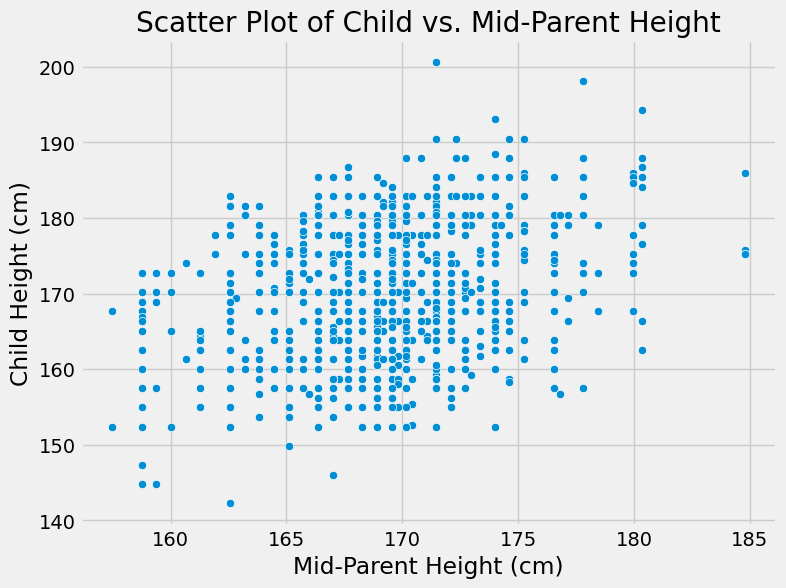

In [16]:
# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x="MidParent", y="Child", data=heights)
plt.xlabel("Mid-Parent Height (cm)")
plt.ylabel("Child Height (cm)")
plt.title("Scatter Plot of Child vs. Mid-Parent Height")
plt.grid(True)
plt.show()

In [17]:
def predict_child(mph, calibrate=0.5*2.2):
    close_points = heights[(heights["MidParent"] >= mph - calibrate) & (heights["MidParent"] <= mph + calibrate)]
    return close_points["Child"].mean()
heights_with_predictions = heights.assign(Prediction = heights.apply(lambda row: predict_child(row['MidParent']), axis=1))

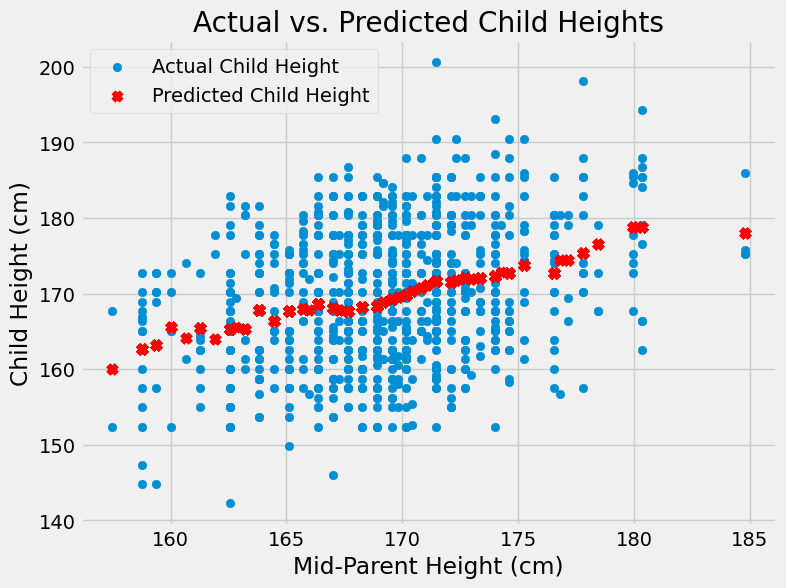

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(heights_with_predictions["MidParent"], heights_with_predictions["Child"], label="Actual Child Height")
plt.scatter(heights_with_predictions["MidParent"], heights_with_predictions["Prediction"], label="Predicted Child Height", marker="x", color="red")

plt.xlabel("Mid-Parent Height (cm)")
plt.ylabel("Child Height (cm)")
plt.title("Actual vs. Predicted Child Heights")
plt.legend()
plt.grid(True)
plt.show()


## 1. Medición en unidades estándar (Estandarización de datos)

Cuando estandarizamos datos, **transformamos los valores originales** para que:
- La **media** sea **0**.
- La **desviación estándar** sea **1**.

Así, los datos se expresan en **unidades de desviación estándar** respecto a la media.

La transformación típica es:

\begin{equation}
z = \frac{x - \mu}{\sigma}
\end{equation}

donde:
- $ x $ es el valor original,
- $ \mu $ es la media de los datos,
- $ \sigma $ es la desviación estándar.


### ¿Qué representa un valor z?
- Indica cuántas desviaciones estándar está el dato \( x \) **por encima o por debajo** de la media.


In [19]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)

In [20]:
heights_SU = pd.DataFrame({
    'MidParent SU': standard_units(heights['MidParent']),
    'Child SU': standard_units(heights['Child'])
})
heights_SU

,MidParent SU,Child SU
0,3.517980,1.804156
1,3.517980,0.686005
2,3.517980,0.630097
3,3.517980,0.630097
4,2.509847,1.888017
...,...,...
929,-1.522685,-0.767591
930,-1.522685,-1.326667
931,-1.522685,-1.606205
932,-2.242780,-0.068747


In [21]:
sd_midparent = np.std(heights["MidParent"])
mean_midparent = np.mean(heights["MidParent"])
print("Standard deviation: ", sd_midparent)
print("Mean: ", mean_midparent)

mean_midparent_SU = np.mean(heights_SU["MidParent SU"])
sd_midparent_SU = np.std(heights_SU["MidParent SU"])
print("Standard deviation in standard units: ", sd_midparent_SU)
print("Mean in standard units: ", mean_midparent_SU)


Standard deviation:  4.409140207321985
Mean:  169.27373126338327
Standard deviation in standard units:  1.0000000000000018
Mean in standard units:  6.8163414479769784e-15


In [22]:
heights_SU

,MidParent SU,Child SU
0,3.517980,1.804156
1,3.517980,0.686005
2,3.517980,0.630097
3,3.517980,0.630097
4,2.509847,1.888017
...,...,...
929,-1.522685,-0.767591
930,-1.522685,-1.326667
931,-1.522685,-1.606205
932,-2.242780,-0.068747


In [23]:
def predict_child_su(mpht_su, pul_to_cm=2.54):

    close = 0.5*pul_to_cm/sd_midparent
    # Use boolean indexing for more efficient filtering in pandas
    close_points = heights_SU[(heights_SU["MidParent SU"] >= mpht_su - close) & (heights_SU["MidParent SU"] <= mpht_su + close)]
    return close_points["Child SU"].mean()
heights_with_predictionsSU = heights_SU.assign(Prediction = heights_SU.apply(lambda row: predict_child_su(row['MidParent SU']), axis=1))
heights_with_predictionsSU

,MidParent SU,Child SU,Prediction
0,3.517980,1.804156,0.937589
1,3.517980,0.686005,0.937589
2,3.517980,0.630097,0.937589
3,3.517980,0.630097,0.937589
4,2.509847,1.888017,1.025864
...,...,...,...
929,-1.522685,-0.767591,-0.466946
930,-1.522685,-1.326667,-0.466946
931,-1.522685,-1.606205,-0.466946
932,-2.242780,-0.068747,-0.703401


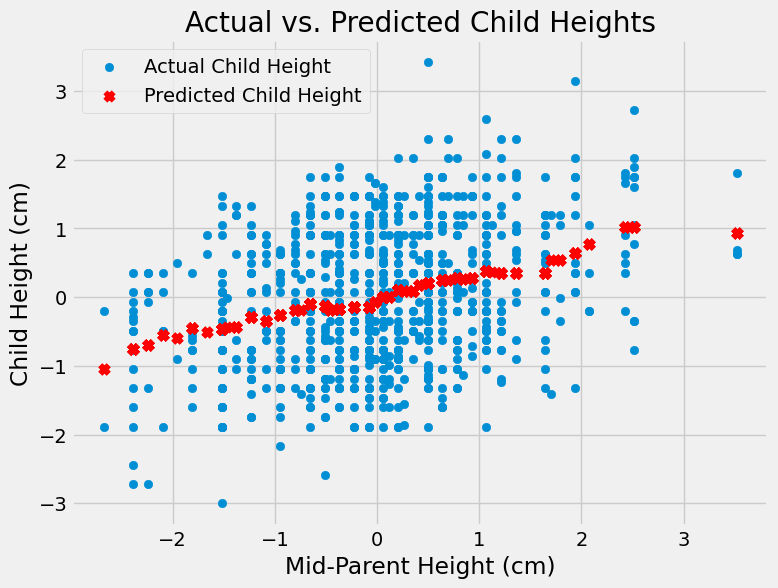

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(heights_with_predictionsSU["MidParent SU"], heights_with_predictionsSU["Child SU"], label="Actual Child Height")
plt.scatter(heights_with_predictionsSU["MidParent SU"], heights_with_predictionsSU["Prediction"], label="Predicted Child Height", marker="x", color="red")

plt.xlabel("Mid-Parent Height (cm)")
plt.ylabel("Child Height (cm)")
plt.title("Actual vs. Predicted Child Heights")
plt.legend()
plt.grid(True)
plt.show()


## 2. Relación entre $ r^2 $ y la pendiente en unidades estándar

En un gráfico donde **x** e **y** están en unidades estándar, la relación entre $ r^2 $ y la pendiente de la recta de regresión es la siguiente:  

## 1. Relación entre $r^2$ y la pendiente  
- La **pendiente de la recta de regresión de $ y $ sobre $ x $** en unidades estándar es **igual al coeficiente de correlación** $r $.  
- El **coeficiente de determinación** $ r^2 $ representa la proporción de la varianza de $ y $ explicada por $ x $.  

Por lo tanto, si la pendiente de la recta de regresión es **$ r $**, entonces:  
\begin{equation}
r^2 = (\text{pendiente})^2
\end{equation}

Es decir, **$ r^2 $ es simplemente el cuadrado de la pendiente**.  

## 2. Interpretación  
- Si la correlación $ r $ es fuerte $ r \approx 1$ o $ r \approx -1 $, la pendiente estará cerca de $ 1 $ o $ -1 $, y $ r^2 $ será alto, lo que indica que la regresión explica casi toda la variabilidad de $y$.  
- Si $r$ es cercano a **0**, la pendiente será pequeña y $ r^2 $ será bajo, indicando que $ x $ explica muy poco la variabilidad de $y$.  


## 3. Ejemplo numérico  
Si $ r = 0.8 $, la pendiente de la recta de regresión es **0.8** y:  
\begin{equation}
r^2 = 0.8^2 = 0.64
\end{equation}
Esto significa que el **64% de la variabilidad de $ y $ es explicada por $ x $**.  



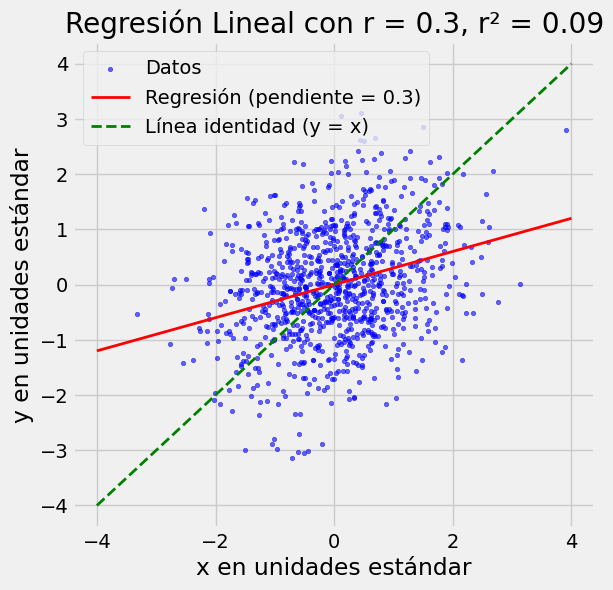

In [27]:
regresion_lineal(0.3)

In [28]:
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t[label_x]) * standard_units(t[label_y]))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r * np.std(t[label_y]) / np.std(t[label_x])

def intercept(t, label_x, label_y):
    return np.mean(t[label_y]) - slope(t, label_x, label_y) * np.mean(t[label_x])

def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz)


In [29]:
family_r = correlation(heights, 'MidParent', 'Child')
family_r

0.3224426772003318

In [30]:
family_slope = slope(heights, 'MidParent', 'Child')
family_intercept = intercept(heights, 'MidParent', 'Child')
family_slope, family_intercept

(0.6644952623525918, 57.05307348762685)

In [31]:
family_slope * 170.0 + family_intercept

170.01726808756746

In [32]:
heights_with_predictions

,MidParent,Child,Prediction
0,184.785,185.928,178.054000
1,184.785,175.768,178.054000
2,184.785,175.260,178.054000
3,184.785,175.260,178.054000
4,180.340,186.690,178.856105
...,...,...,...
929,162.560,162.560,165.291796
930,162.560,157.480,165.291796
931,162.560,154.940,165.291796
932,159.385,168.910,163.143259
